# Simple machine learning models from scratch

This notebook uses tensors to implement a linear regressor, a linear classifier, and a multi-Layer perceptron.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

Let's start by seeding PyTorch random generator so as to be able to reproduce the results.

In [2]:
torch.manual_seed(17)

## Simple linear regression
The goal of this section is fit a simple line to the following data:

In [3]:
x = torch.arange(0, 15, .3)
y = 3 * x + 2 + torch.normal(mean=2, std=5, size=(len(x),))

And let's plot the data:

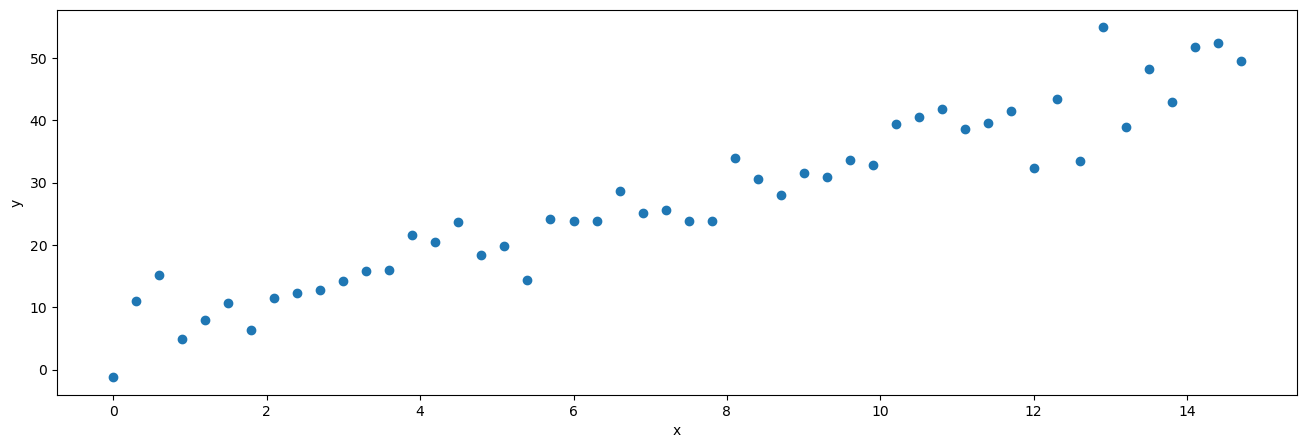

In [4]:
fig = plt.figure(figsize=(16,5))
plt.scatter(x, y, marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Model description
For a single data example $(\mathbf{x}, y)$, the linear regression model is defined as:

$$h(\mathbf{x}) = b + \mathbf{x} \mathbf{w} = b + w_1 x_1 + w_2 x_2 + \cdots + w_m x_m$$

where $m$ is the number of features, $b$ is the bias parameter (or intercept), and $w_1, \cdots, w_m$ are weight parameters.

The goal is to learn the values of $b$ and $w_1, \cdots, w_m$ parameters that minimize the mean squared error (MSE) loss defined as:

$$ L(b, \mathbf{w}) = \frac{1}{N}\sum_{i=1}^N (y^{(i)} - \hat{y}^{(i)})^2 = \frac{1}{N}\sum_{i=1}^N (y^{(i)} - (b + \mathbf{x}^{(i)} \mathbf{w}))^2$$


A **simple linear regression model** is defined using the familiar equation:

$$ y = w x + b$$


### Implementation

Using **gradient descent**, we can find optimal or near-optimal values for the `b` and `w` parameters using the following iterative five-step algorithm.

* **STEP 1**: Initialize the parameters $b$ and $w_1, \cdots, w_m$.
* Inside the training loop:
    * **STEP 2**: Calculate the predicted output.
    * **STEP 3**: Calculate the loss function.
    * **STEP 4**: Calculate the gradients of the loss function with respect to the $b$ and $w_1, \cdots, w_m$ parameters.
    * **STEP 5**: Update the values of the $b$ and $w_1, \cdots, w_m$ parameters using the gradient descent update rules:
        $$b = b - \eta \frac{\partial L}{\partial b}$$
        $$w_i = w_i - \eta \frac{\partial L}{\partial w_i}$$
        where $\eta$ is the learning rate.

Let's start by normalizing the input tensor `x`:

In [5]:
x = (x - torch.mean(x))/torch.std(x)

Now, we follow the above 5-step algorithm.

**STEP 1**: Initialize the parameters: $b$ to zero and $w_1, \cdots, w_m$ to small random values. Because the algorithm requires calculating the gradients of the loss function with respect to these two variables, they will need to have their `requires_grad=` attribute set to true.

In [6]:
b = torch.tensor(.0, requires_grad=True)
w = torch.normal(mean=.1, std=.2, size=(1,), requires_grad=True)
b, w

(tensor(0., requires_grad=True), tensor([0.0209], requires_grad=True))

The next steps require being able to calculate the predicted output and the loss (the mean square error, in this case). Here are two functions for doing that:

In [7]:
def predict(x):
    return w * x + b

def loss_fn(y_actual, y_predicted):
    return torch.mean((y_actual - y_predicted)**2)

Having completed that, let's implement the remaining steps inside the training loop. This loop runs multiple times; each iteration over the whole training set is called **an epoch**.

In [8]:
epochs = 20
eta = 0.1 # The learning rate
history = { "biases": [], "weights": [], "losses": [] } # For tracking progress
for i in range(epochs):    
    # STEP 2: Calculate the predicted output 
    y_predicted = predict(x)
    
    # STEP 3: Calculate the loss function
    loss = loss_fn(y, y_predicted)
    
    # STEP 4: Calculate the gradients of the loss with respect to b and w
    loss.backward()

    # STEP 5: Update the b and w parameters.
    with torch.no_grad():
        b -= eta * b.grad
        w -= eta * w.grad

    w.grad.zero_()
    b.grad.zero_()
    
    # Tracking progress
    history["biases"].append(b.item())
    history["weights"].append(w.item())
    history["losses"].append(loss.item())

Let's plot the data and the trained regression line. Along with that we'll plot the progress of the b, w, and loss function.

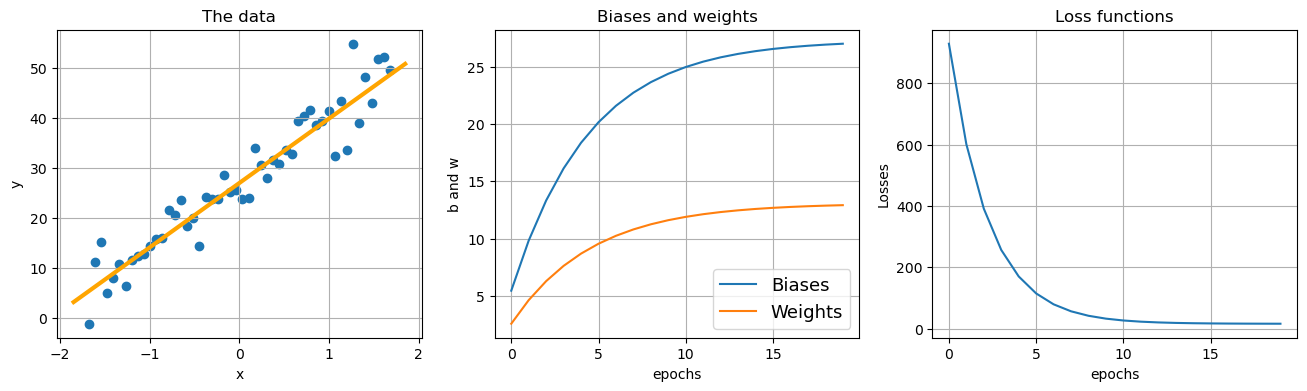

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

ax[0].scatter(x, y, marker='o')
x1, x2 = ax[0].get_xlim()
# x = x.numpy()
input = (torch.tensor([[x1], [x2]]) - torch.mean(x))/torch.std(x)
output = predict(input)
ax[0].plot((x1, x2), output.detach().numpy(), color="orange", linewidth=3)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('The data')
ax[0].grid()

# Plot the progress of b and w
ax[1].plot(history["biases"], label="Biases")
ax[1].plot(history["weights"], label="Weights")
ax[1].legend(fontsize=13)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('b and w')
ax[1].set_title('Biases and weights')
ax[1].grid()

# Plot the decay of loss function
ax[2].plot(history["losses"])
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Losses')
ax[2].set_title('Loss functions')
ax[2].grid()

plt.show()

## Linear classification
We have the following data:

In [10]:
n_per_class = 300

# Class 0 data
X0 = np.random.multivariate_normal(
    mean=[1, 5],
    cov=[[1, 0.5],[0.5, 1]],
    size=n_per_class)

# Class 1 data
X1 = np.random.multivariate_normal(
    mean=[5, 3],
    cov=[[1, 0.6], [0.6, 1]],
    size=n_per_class)

# Putting the data together
X = torch.tensor(np.concatenate((X0, X1), axis=0), dtype=torch.float32)
y = torch.concatenate((torch.zeros(n_per_class, 1), torch.ones(n_per_class, 1)), axis=0)
print(X.shape, y.shape)

torch.Size([600, 2]) torch.Size([600, 1])


which looks like this:

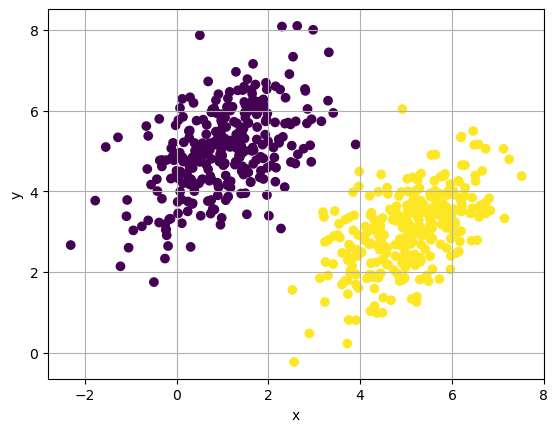

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y[:, 0])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Our job is create a linear classification model that separates these two classes. Looking at the data we have 2D input tensor X and a 1D outout tensor

In [12]:
X.shape, y.shape

(torch.Size([600, 2]), torch.Size([600, 1]))

### Model description
Next we implement a linear classifier. This model will implement a boundary line whose equation is:

$$w_1 x_1 + w_2 x_2 + b = .5$$

where .5 is the threshold. If the predicted output is > 0.5, the class is 1 else it is 0. 

### Implementation

This is going to be similar to the previous model. Let's define two functions: one for calculating the predicted value and another for calculating the loss:

In [13]:
def predict(X):
    return torch.matmul(X, W) + b

def loss_function(y_actual, y_predicted):
    return torch.mean((y_actual - y_predicted)**2)

We now follow the above gradient-descent steps.

**STEP 1**: Initialize the parameters. Because the input is two-dimensional, there will be two weights arranged in a weight vector `W`. Both tensors `b` and `W` must have their `requires_grad` attributes set to true.

In [14]:
b = torch.tensor(.0, requires_grad=True)
W = torch.normal(mean=.1, std=.2, size=(2, 1), requires_grad=True)

And here is the training loop with the rest of the steps (2 - 4).

In [15]:
epochs = 25
eta = 0.01 # The learning rate
history = { "biases": [], "weights": [], "losses": [] } # For tracking progress
for i in range(epochs): 
    # STEP 2: Calculate the predicted output 
    y_predicted = predict(X)
    
    # STEP 3: Calculate the loss function
    loss = loss_function(y, y_predicted)
    
    # STEP 4: Calculate the gradients of the loss with respect to b and w
    loss.backward()
    
    # STEP 5: Update the b and w parameters.
    with torch.no_grad():
        b -= eta * b.grad
        W -= eta * W.grad

    b.grad.zero_()
    W.grad.zero_()
    # Tracking progress
    history["biases"].append(b.item())
    history["weights"].append(W.detach().numpy())
    history["losses"].append(loss.item())

Let's plot the results of this model along with the original data and the loss curve.

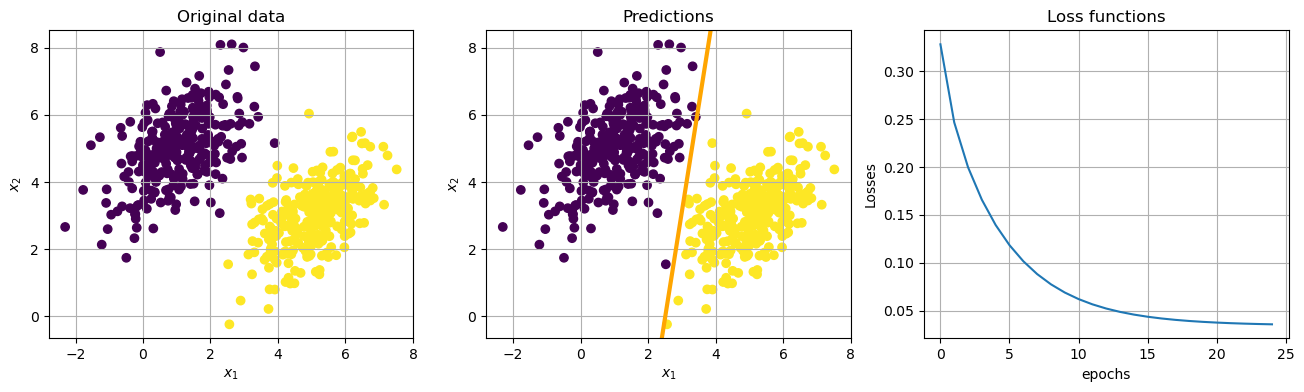

In [16]:
fig = plt.figure(figsize=(16,4))

plt.subplot(1, 3, 1)
predictions = predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Original data')
plt.grid()

plt.subplot(1, 3, 2)
predictions = predict(X)
plt.scatter(X[:, 0], X[:, 1], c=predictions[:, 0] > 0.5)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

x1 = torch.linspace(xmin, xmax, 2)
x2 = (- W[0] /  W[1] * x1 + (0.5 - b) / W[1]).detach()

plt.plot(x1, x2, color="orange", linewidth=3)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Predictions')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(history["losses"])
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.title('Loss functions')
plt.grid()

## Multi-layer Perceptron

An example of a more involved implementation is to create a simple multi-layer perceptron model from scratch and use it for binary classification using the previous two-class data.

### Model Description

As the name implies, a multilayer perceptron (MLP) is a set of perceptrons arranged into layers. For this implementation, we will use the ReLU activation function (`torch.nn.ReLU`) for the hidden layer and the logistic (sigmoid) activation function (`torch.nn.Sigmoid`) for the output layer. This model will constitute a simple fully-connected neural network that looks like this:

<img style="-webkit-user-select:none; display:block; margin:auto; padding:env(safe-area-inset-top) env(safe-area-inset-right) env(safe-area-inset-bottom) env(safe-area-inset-left);" src="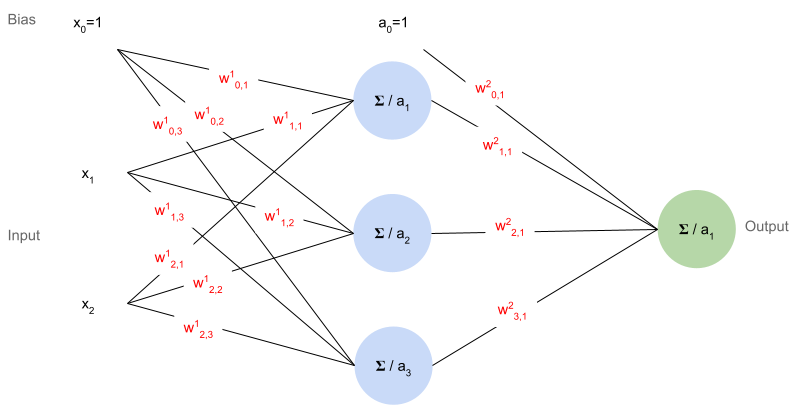">

Here we have three layers: input, hidden, and output.

### Implementation

We'll be more organized in our implementation and use a Python class that puts all steps together.

In [17]:
import torch.nn as nn

class MLPClassifier:
    def __init__(self, nHidden, nOutput=1):
        self.nHidden = nHidden
        self.nOutput = nOutput
        self.W = []
    
    def MSE(self, actual, predicted):
        return torch.mean((actual - predicted)**2)
    
    def forward(self, X):
        X = torch.concat([torch.ones(len(X),1), X],axis=1)
        
        """ Activations of hidden layer """
        self.a = nn.ReLU()(torch.matmul(X, self.W[0]));
        # Adding bias to the hidden layer
        self.a = torch.concat([torch.ones(len(self.a), 1), self.a], axis=1)

        return nn.Sigmoid()(torch.matmul(self.a, self.W[1]))
        
    def fit(self, X, y, epochs=200, eta=0.01):
        N, M = X.shape
        self.errors = []
        
        # STEP 1: Initialize parameters
        self.W.append(
            torch.normal(mean=.1, std=.2, size=(M + 1, self.nHidden), requires_grad=True))
        self.W.append(
            torch.normal(mean=.1, std=.2, size=(self.nHidden + 1, self.nOutput), requires_grad=True))
        
        history = { "losses": [] } # For tracking progress
        for n in range(epochs):
            # STEP 2: Calculate the predicted output 
            y_predicted = self.forward(X)
    
            # STEP 3: Calculate the loss function
            loss = self.MSE(y, y_predicted)
    
            # STEP 4: Calculate the gradients of the loss with respect the W parameters
            loss.backward()
            # grad_W0, grad_W1 = tape.gradient(loss, [self.W[0], self.W[1]])

            # STEP 5: Update the W parameters.
            with torch.no_grad():
                self.W[0] -= eta * self.W[0].grad
                self.W[1] -= eta * self.W[1].grad
        
            self.W[0].grad.zero_()
            self.W[1].grad.zero_()
        
            history["losses"].append(loss.item())
            
        return history
    def predict(self, X):
        return (self.forward(X)[:, 0] > 0.5).to(dtype=torch.int)

Here, we have two sets of weights: the weights between the input and hidden layers and the weights between the hidden and output layers. The two biases are folded into these weight sets (with `0` subscripts). Let's test this class using the same data as the linear classifier above.

In [18]:
mlp = MLPClassifier(16, 1)
history = mlp.fit(X, y, epochs=500)

And here are the results.

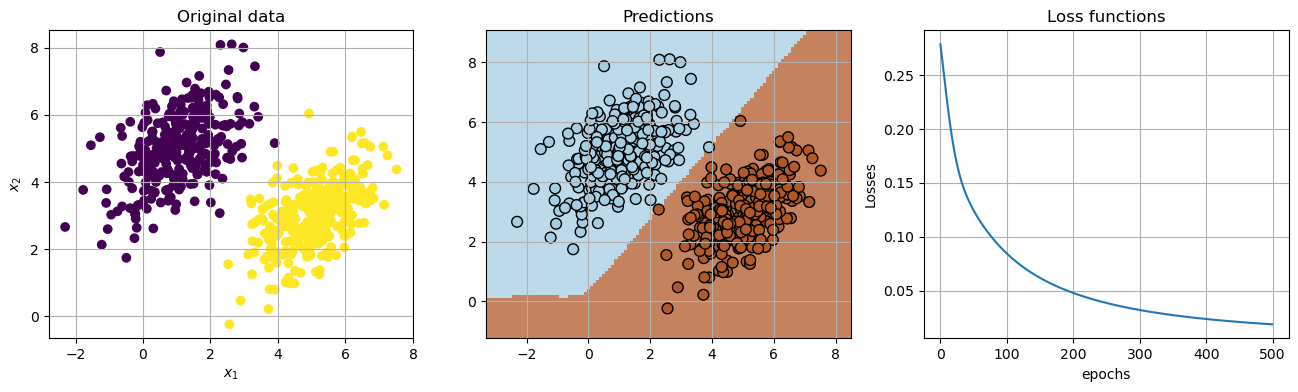

In [19]:
def plot_decision_regions(X, y, learner, resolution=0.1, title="Decision regions", ax=None):    
    if ax is None:
        fig = plt.figure(figsize=(16,9))
        ax = fig.add_subplot(1,1,1)
        
    # Plot the decision boundary.
    x_min, x_max = torch.min(X[:,0]) - 1, torch.max(X[:,0]) + 1
    y_min, y_max = torch.min(X[:,1]) - 1, torch.max(X[:,1]) + 1
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, resolution),
                         torch.arange(y_min, y_max, resolution), indexing="ij")
    # print(torch.stack((xx.ravel(), yy.ravel())).T)
    Z = learner.predict(torch.stack((xx.ravel(), yy.ravel())).T)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.rcParams['pcolor.shading'] ='nearest'
    ax.pcolormesh(xx.numpy(), yy.numpy(), Z.numpy(), cmap=plt.cm.Paired, alpha=.75)

    # Plot the points
    ax.scatter(
        x=X[:, 0],
        y=X[:, 1], c=y, cmap=plt.cm.Paired,
        edgecolor='k', s=60)
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    # plt.legend(loc='best')
    ax.set_title(title)
    
fig, ax = plt.subplots(1, 3, figsize=(16,4))

ax[0].scatter(X[:, 0], X[:, 1], c=y[:, 0])
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[0].set_title('Original data')
ax[0].grid()

predictions = mlp.predict(X)
plot_decision_regions(X, mlp.predict(X), mlp, ax=ax[1])

ax[1].set_title('Predictions')
ax[1].grid()

# Plot the decay of loss function
ax[2].plot(history["losses"])
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Losses')
ax[2].set_title('Loss functions')
ax[2].grid()

plt.show()

which is not bad, giving us the accuracy:

In [20]:
from sklearn.metrics import accuracy_score

accuracy_score(y, mlp.predict(X))

0.9983333333333333

and the confusion matrix

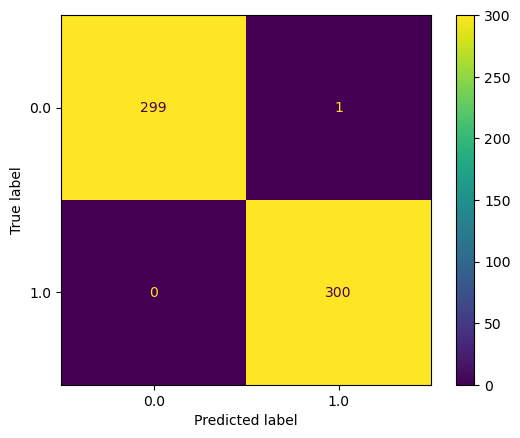

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y, mlp.predict(X))